<h1>Batch processing of price paid data from HM Land Registry</h1>
<h2>Introduction</h2>
<p align="justify">UK Government departments have made lot of interesting datasets publicly available. HM land registry price paid data set is one such evergrowing dataset published by UK government.It contains residential property records for more than 20 years. Following analaysis is based on a dataset corresponding to UK house prices for the time duration 1995-2018. This price paid dataset was combined with a UK postcodes dataset from Royal Mail for further analysis. Both datasets are currently stored at AWS S3.</p>

House prices dataset is available for download from here: <br/>
https://s3-eu-west-1.amazonaws.com/land-registry-price-paid-data/pp-complete.csv

Postcodes dataset is available for download from here: <br/>
https://s3-eu-west-1.amazonaws.com/land-registry-price-paid-data/postcodes.csv

More information about HM Land Registry and Royal Mail can be found using following links. 
<br/>https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads
<br/>https://www.gov.uk/guidance/about-the-price-paid-data
<br/>https://www.poweredbypaf.com/product/bfpo-postcode-data/

<p>Architectures used: An Apache Spark cluster running on AWS EMR using Yarn as resource manager.<br/>
Programming language used: Python </p>


<h2>Analysis</h2>

In [69]:
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import (StructType,StructField,StringType,FloatType,DoubleType,IntegerType,DateType)
from pyspark.sql.functions import *

from pyspark.ml.feature import VectorAssembler,StandardScaler
from pyspark.ml.clustering import KMeans

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics

from math import cos, asin, sqrt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
session= SparkSession.builder.appName('HMLandRegistry').getOrCreate()
# Creates a pyspark.sql.session.SparkSession object.

Following schema was used to process price paid dataset. 

<table align="center">
    <tr><th>Column name</th><th>Data description</th></tr>
    <tr><td align="left">identifier</td><td>Unique transaction reference number</td></tr>
    <tr><td>price</td><td>Sale price</td></tr>
    <tr><td>sale_date</td><td>Data of sales completion</td></tr>
    <tr><td>postcode</td><td>Postcode of property</td></tr>
    <tr><td>property_type</td><td>D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other </td></tr>
    <tr><td>old_new</td><td>Y = a newly built property, N = an established residential building</td></tr>
    <tr><td>duration</td><td>Relates to the tenure: F = Freehold, L= Leasehold</td></tr>
    <tr><td>PAON</td><td>Primary address object, for example house name or number</td></tr>
    <tr><td>SAON</td><td>Secondary address object, when a property is divided into further separate units</td></tr>
    <tr><td>Street</td><td>Street</td></tr>
    <tr><td>locality</td><td>Locality</td></tr>
    <tr><td>town_city</td><td>Town/City</td></tr>
    <tr><td>district</td><td>District</td></tr>
    <tr><td>county</td><td>County</td></tr>
    <tr><td>category</td><td>A = Standard Price Paid entry, B = Additional Price Paid entry</td></tr>
    <tr><td>record_status</td><td>A = Addition, C = Change, D = Delete.</td></tr>
</table>
<br/>

Following webpage further ellaborates the schema. <br/>

https://www.gov.uk/guidance/about-the-price-paid-data#explanations-of-column-headers-in-the-ppd


In [3]:
data_schema = [StructField('identifier',StringType(),True),
               StructField('price',FloatType(),True), 
               StructField('sale_date',DateType(),True),
               StructField('postcode',StringType(),True),
               StructField('property_type',StringType(),True),
               StructField('old_new',StringType(),True),
               StructField('duration',StringType(),True),
               StructField('PAON',StringType(),True),
               StructField('SAON',StringType(),True),
               StructField('street',StringType(),True),
               StructField('locality',StringType(),True),
               StructField('town_city',StringType(),True),
               StructField('district',StringType(),True),
               StructField('county',StringType(),True),
               StructField('category',StringType(),True),
               StructField('record_status',StringType(),True)
              ]

final_struc = StructType(fields= data_schema)

<p>All the entries with null values for sale date or postcode or price were dropped and those three columns were selected for further analysis. </p>

In [4]:
# Creates a pyspark.sql.Dataframe object.
df_ppd= session.read.csv('s3a://land-registry-price-paid-data/pp-complete.csv',schema =final_struc)
df_ppd = df_ppd.select('sale_date','postcode','price').na.drop()

In [8]:
df_ppd.show(5)

+----------+--------+-------+
| sale_date|postcode|  price|
+----------+--------+-------+
|1995-12-21| NE4 9DN|42000.0|
|1995-03-03|RM16 4UR|95000.0|
|1995-10-03|CW10 9ES|74950.0|
|1995-11-14|TS23 3LA|43500.0|
|1995-09-08|CA25 5QH|63000.0|
+----------+--------+-------+
only showing top 5 rows



<p><b>Preparing postcodes dataset for integration:</b></p>

In [5]:
df_postcode = session.read.csv('s3a://land-registry-price-paid-data/postcodes.csv',inferSchema=True, header=True)
df_postcode.head(1)

[Row(Postcode=u'AB1 0AA', In Use?=u'No', Latitude=57.101474, Longitude=-2.242851, Easting=385386, Northing=801193, Grid Ref=u'NJ853011', County=None, District=u'Aberdeen City', Ward=u'Lower Deeside', District Code=u'S12000033', Ward Code=u'S13002843', Country=u'Scotland', County Code=u'S99999999', Constituency=u'Aberdeen South', Introduced=datetime.datetime(1980, 1, 1, 0, 0), Terminated=datetime.datetime(1996, 6, 1, 0, 0), Parish=None, National Park=None, Population=None, Households=None, Built up area=None, Built up sub-division=None, Lower layer super output area=u'Cults, Bieldside and Milltimber West - 02', Rural/urban=u'Accessible small town', Region=None, Altitude=46, London zone=None, LSOA Code=u'S01006514', Local authority=None, MSOA Code=u'S02001237', Middle layer super output area=u'Cults, Bieldside and Milltimber West', Parish Code=None, Census output area=u'S00090303', Constituency Code=u'S14000002', Index of Multiple Deprivation=6808, Quality=1, User Type=0, Last updated=da

<p>Postcodes currently in use were selected for further analysis.</p>

In [6]:
df_postcode = df_postcode.filter(df_postcode['In Use?'] != 'No').select(['Postcode','Latitude','Longitude']).\
withColumnRenamed('Postcode','postcode')

In [7]:
# A function to find distance from W1J 7NT post code to given latitude and longitude combination. 
def dist_to_london_km(lat2, lon2):
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - 51.754163) * p)/2 + cos(51.754163 * p) * cos(lat2 * p) * (1 - cos((lon2 - (-0.309668)) * p)) / 2
    return 12742 * asin(sqrt(a)) #2*R*asin...
udf_dist_to_london_km = udf(dist_to_london_km, DoubleType())

<p>The centre of london was assumed as W1J 7NT postcode. For each transaction the distance between the property and cente of London was calculated. It was added as a new column to the dataframe. </p>

In [9]:
df_postcode= df_postcode.withColumn("distance_to_london_km",udf_dist_to_london_km('Latitude','Longitude')).\
withColumn('distance_to_london_km',format_number('distance_to_london_km',2))

df_postcode= df_postcode.withColumn('distance_to_london_km', df_postcode['distance_to_london_km'].cast(FloatType()))

In [10]:
df_postcode.persist()

DataFrame[postcode: string, Latitude: double, Longitude: double, distance_to_london_km: float]

<p>Joining two dataframes: Price paid data and postcodes</p>

In [11]:
df_ppd = df_ppd.join(df_postcode.select('postcode'),['postcode'])

<p><b>Summaries for dataset after joining:</b></p>

In [95]:
summaries = df_ppd.describe()
summaries.select(['summary','postcode','price']).withColumn('price',round('price',2)).show()

+-------+--------+-----------+
|summary|postcode|      price|
+-------+--------+-----------+
|  count|23273433|2.3273433E7|
|   mean|    null|   184700.8|
| stddev|    null|  595901.91|
|    min| AL1 1AJ|        1.0|
|    max|YO91 1RT|5.9430003E8|
+-------+--------+-----------+



For each sale, year and month sale happened were recorded seperately instead of sale date.

In [13]:
df_ppd= df_ppd.withColumn('year', year('sale_date')).withColumn('month', month('sale_date')).drop('sale_date')
df_ppd.persist()

DataFrame[postcode: string, price: float, year: int, month: int]

In [138]:
# A function to extract first digits of the postcode up to the space. 
def postcode_prefix(postcode):
    return postcode.split()[0]
udf_postcode_prefix = udf(postcode_prefix, StringType())

Postcode prefix was defined as first digits of the postcode up to the space. For each transaction, postcode prefix were stored and full postcode was dropped. 

In [141]:
df_ppd_pcPrefix= df_ppd.withColumn("postcode_prefix",udf_postcode_prefix('postcode')).drop('postcode')
df_ppd_pcPrefix.persist()

DataFrame[price: float, year: int, month: int, postcode_prefix: string]

<p><b>Finding the maximum, average and median price paid overall for each year:</b></p>

In [236]:
# finding maximum, average price per each year.
df_min_max_avg = df_ppd_pcPrefix.groupby('year').agg(max('price'),avg('price')).\
withColumn('avg(price)',format_number('avg(price)',2))

In [237]:
# finding median price for each year. 
df_ppd_pcPrefix.createOrReplaceTempView("ppd_pcPrefix")
df_median = session.sql("select year, percentile_approx(price, 0.5) as median from ppd_pcPrefix group by year")

df_min_max_avg_med = df_min_max_avg.join(df_median,'year').orderBy('year')

In [239]:
# function to drop commas in prices.
def dropComma(price):
    aList = price.split(',')
    return float(''.join(aList))

udf_dropComma = udf(dropComma, DoubleType())

Commas in prices introduce errors in analysis. So that commas in avg(price) was removed. 

In [240]:
df_min_max_avg_med= df_min_max_avg_med.withColumn('avg(price)',udf_dropComma(col('avg(price)')))
df_min_max_avg_med.select(['year','max(price)','avg(price)','median']).show(24)

+----+------------+----------+--------+
|year|  max(price)|avg(price)|  median|
+----+------------+----------+--------+
|1995|   5610000.0|  67952.11| 54950.0|
|1996|   7000000.0|  71507.09| 57000.0|
|1997|   6107000.0|  78535.61| 60000.0|
|1998|      2.15E7|  85421.57| 65000.0|
|1999|    3.2477E7|  96017.24| 72950.0|
|2000|      1.26E7| 107479.45| 80000.0|
|2001|     2.475E7|  118908.4| 90000.0|
|2002|   8300000.0| 138026.33|110000.0|
|2003|   9250000.0|  156007.9|130000.0|
|2004|  9.255592E7| 179109.14|150000.0|
|2005|  1.519395E7| 189567.16|157695.0|
|2006|      1.24E7| 203637.19|166000.0|
|2007|       1.7E7| 219489.14|175455.0|
|2008|      2.35E7| 217039.25|170000.0|
|2009|      1.38E7| 213440.57|169000.0|
|2010|      1.62E7| 236024.17|182000.0|
|2011|       2.1E7|  232625.7|176000.0|
|2012|    5.4959E7| 238228.86|180000.0|
|2013|       9.2E7| 255280.25|184950.0|
|2014|     1.325E8| 276619.83|190000.0|
|2015|1.55146688E8| 293629.12|204995.0|
|2016|       3.3E8| 307441.27|215000.0|


<p><b>Plotting change of average and median house prices in UK over time as two line graphs:</b></p>

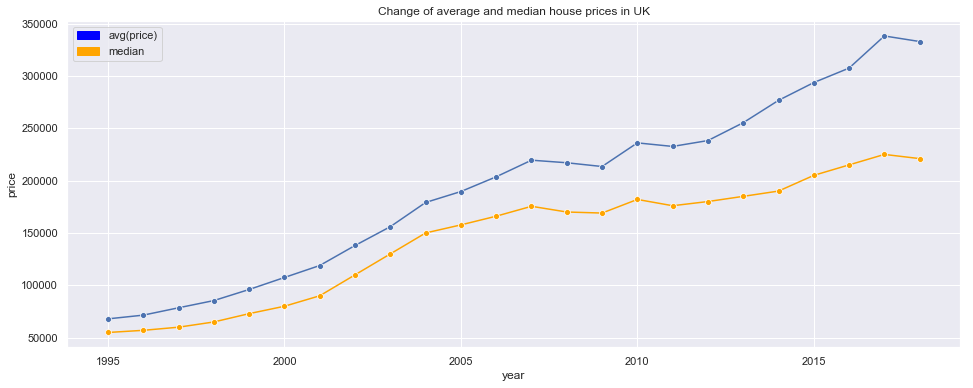

In [196]:
df_min_max_avg_med = df_min_max_avg_med.toPandas()
avg_handler = mpatches.Patch(color='blue',label='avg(price)')
median_handler = mpatches.Patch(color='orange',label='median')

plt.figure(figsize=(16, 6))
plt.legend(handles=[avg_handler,median_handler])

sns.set()
g = sns.lineplot(x="year", y="avg(price)",data=df_min_max_avg_med,marker="o",lw=1.5)
g = sns.lineplot(x="year", y="median",data=df_min_max_avg_med,marker="o",lw=1.5, color='orange')
h =g.set(ylabel='price',title='Change of average and median house prices in UK')

<p><b>Calculating top ten largest differences between the minimum and maximum prices paid for 2017, for each postcode prefix:</b></p>

In [242]:
# grouping by postcode_prefix,year and finding min(price),max(price),avg(price) 
# for each prefix and year combination.
df_stats_per_prefixAndYear = df_ppd_pcPrefix.groupby('postcode_prefix','year').\
agg(min('price'),max('price'),avg('price')).withColumn('avg(price)',format_number('avg(price)',2))

In [243]:
# calculating the difference between max(price) and min(price) per each row. 
df_stats_per_prefixAndYear= df_stats_per_prefixAndYear.\
withColumn("range",df_stats_per_prefixAndYear["max(price)"]- df_stats_per_prefixAndYear["min(price)"])

In [193]:
# filtering records based on year 2017. 
df_stats_per_prefix_2017 = df_stats_per_prefixAndYear.filter("year == 2017").orderBy(col('range').desc()).\
drop('year').limit(10)
df_stats_per_prefix_2017.show()

+---------------+----------+------------+-------------+------------+
|postcode_prefix|min(price)|  max(price)|   avg(price)|       range|
+---------------+----------+------------+-------------+------------+
|            W1U|    2000.0| 5.9430003E8|12,064,146.54| 5.9429805E8|
|             L8|   10000.0|       3.0E8| 9,669,279.93|2.99990016E8|
|            W14|    5500.0|       2.8E8| 1,985,612.86|2.79994496E8|
|           EC3M|   37500.0|2.70798592E8|57,226,218.40|2.70761088E8|
|           EC2N|  336970.0|       2.6E8|64,899,924.29|2.59663024E8|
|           SW1W|   20000.0|     2.154E8| 3,008,495.47|    2.1538E8|
|            W1T|   47500.0|      1.97E8| 6,478,832.50|1.96952496E8|
|           EC1A|  500000.0|1.75018288E8| 7,470,743.06|1.74518288E8|
|            B69|    9120.0|1.67499808E8|   559,536.03|1.67490688E8|
|           EC2V|    3096.0|       1.6E8|17,521,795.55|1.59996896E8|
+---------------+----------+------------+-------------+------------+



<p><b>Plotting top ten ranges in house prices against postcode prefix in 2017:<br/>
    range = maximum price - minimum price</b></p>



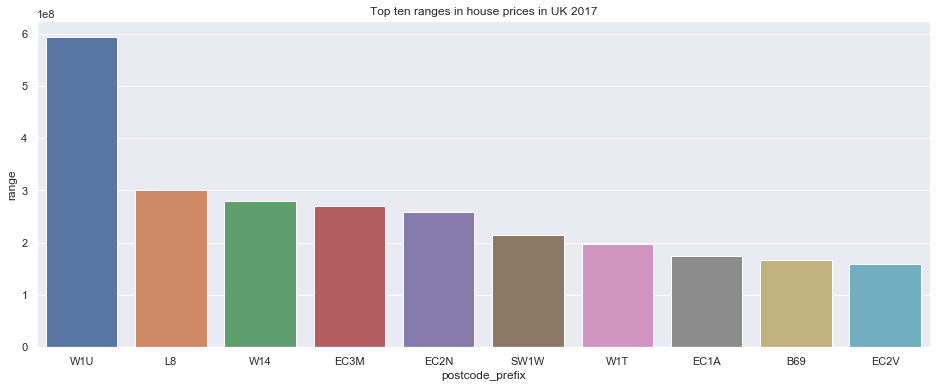

In [204]:
df_stats_per_prefix_2017 = df_stats_per_prefix_2017.toPandas()
plt.figure(figsize=(16, 6))
sns.set()

g = sns.barplot(x='postcode_prefix',y='range',data=df_stats_per_prefix_2017)
h =g.set(title='Top ten ranges in house prices in UK 2017')

<p><b>Finding ten postcode prefixes that had the biggest increase in average price paid from 2001 to 2017:</b></p>

In [260]:
# filtering previous dataframe df_stats_per_prefixAndYear based on year 2017
df_avg2017 = df_stats_per_prefixAndYear.filter("year == 2017").\
select(['postcode_prefix','avg(price)']).withColumnRenamed('avg(price)','avg_2017')

In [261]:
# filtering previous dataframe df_stats_per_prefixAndYear based on year 2001
df_avg2001 = df_stats_per_prefixAndYear.filter("year == 2001").\
select(['postcode_prefix','avg(price)']).withColumnRenamed('avg(price)','avg_2001') 

In [262]:
# joinig df_avg2017 and df_avg2001
df_avg2017_2001= df_avg2017.join(df_avg2001,'postcode_prefix')

In [263]:
df_avg2017_2001.printSchema()

root
 |-- postcode_prefix: string (nullable = true)
 |-- avg_2017: string (nullable = true)
 |-- avg_2001: string (nullable = true)



In [264]:
# dropping commas in prices
df_avg2017_2001 = df_avg2017_2001.withColumn('avg_2017',udf_dropComma(col('avg_2017'))).\
withColumn('avg_2001',udf_dropComma(col('avg_2001')))

In [266]:
# calculating increases in average prices
df_avg2017_2001 = df_avg2017_2001.withColumn("increase",df_avg2017_2001["avg_2017"]- df_avg2017_2001["avg_2001"]).\
withColumn("increase",format_number(col('increase'),2))

In [268]:
avg2017_2001_Df = avg2017_2001_Df.orderBy(col('increase').desc()).limit(10)
avg2017_2001_Df.show()

+---------------+----------+---------+----------+
|postcode_prefix|  avg_2017| avg_2001|  increase|
+---------------+----------+---------+----------+
|            SW5|1400333.85|405313.62|995,020.23|
|            WV2| 138883.43| 38891.56| 99,991.87|
|            B43| 185746.48| 85843.78| 99,902.70|
|           CA14| 152822.29| 53062.81| 99,759.48|
|            S20| 173160.57|  73425.5| 99,735.07|
|           HU12| 164241.39| 64523.79| 99,717.60|
|            S21| 164198.32| 64497.43| 99,700.89|
|             B1| 254645.29|155082.05| 99,563.24|
|            B65|  160656.9|  61272.2| 99,384.70|
|            DL9| 155276.66| 55932.01| 99,344.65|
+---------------+----------+---------+----------+



<p><b>Finding monthly averages of transactions across all years:</b></p>

In [293]:
# counting number of transactions per month
df_transac_per_month = df_ppd_pcPrefix.groupby('month').count().withColumnRenamed('count','transac_count')

In [294]:
# counting number of transactions per month,year combination.
# then again grouping by month and getting count. 
# this results year count per month. 
df_year_count = df_ppd_pcPrefix.groupby('month','year').count().groupby('month').count().\
withColumnRenamed('count','year_count')

In [295]:
df = df_transac_per_month.join(df_year_count,'month')

In [296]:
df = df.withColumn("avg(numTransactions)",df["transac_count"]/ df["year_count"]).\
select(['month','avg(numTransactions)']).orderBy(col('avg(numTransactions)').desc())

In [297]:
df.show()

+-----+--------------------+
|month|avg(numTransactions)|
+-----+--------------------+
|    7|             95141.0|
|    8|   94962.08695652174|
|    6|   91554.13043478261|
|   10|   89054.82608695653|
|   12|             88233.0|
|   11|   87255.65217391304|
|    9|   86592.39130434782|
|    5|   84060.21739130435|
|    3|   80470.54166666667|
|    4|   73740.29166666667|
|    2|  64288.458333333336|
|    1|           62428.875|
+-----+--------------------+



<p><b>Plotting average number of transactions per month:</b></p>

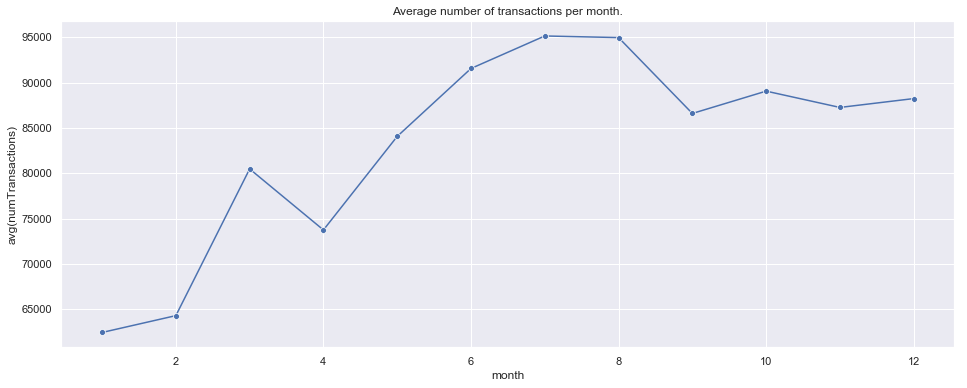

In [301]:
df = df.toPandas()
plt.figure(figsize=(16, 6))

sns.set()
g = sns.lineplot(x="month", y="avg(numTransactions)",data=df,marker="o",lw=1.5)
h =g.set(ylabel='avg(numTransactions)',xlabel='month',title='Average number of transactions per month.')

<p><b>Creating 20 geographic clusters of transactions using number of transactions for year 2017: </b></p>

In [14]:
df_trans_count_per_postcode = df_ppd.filter("year == 2017").groupby('postcode').count().join(df_postcode,'postcode')
df_trans_count_per_postcode.columns

['postcode', 'count', 'Latitude', 'Longitude', 'distance_to_london_km']

In [39]:
# adding a features column. Datatype of features column will be Vector. 
df_forKMeans = VectorAssembler(inputCols=['Latitude', 'Longitude', 'distance_to_london_km'], outputCol="features").\
transform(df_trans_count_per_postcode)

# featue Scaling
scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures') 
scalerModel = scaler.fit(df_forKMeans) 
df_forKMeans = scalerModel.transform(df_forKMeans)

df_forKMeans.select(['features','scaledFeatures']).show(5,truncate=False)

+----------------------------------------+--------------------------------------------------------------+
|features                                |scaledFeatures                                                |
+----------------------------------------+--------------------------------------------------------------+
|[51.747564,-0.341943,2.3399999141693115]|[45.164388834027065,-0.25436123870737715,0.024305652464176507]|
|[51.737026,-0.318563,2.0]               |[45.15519144785575,-0.2369695513180214,0.020774062697181673]  |
|[51.766624,-0.231886,5.53000020980835]  |[45.18102407604883,-0.1724931061577481,0.05744028553699323]   |
|[51.725112,-0.35222,4.360000133514404]  |[45.1447931124178,-0.26200599368173166,0.04528745806667435]   |
|[51.797803,-0.402417,8.020000457763672] |[45.20823657400247,-0.2993460506485192,0.08330399617050412]   |
+----------------------------------------+--------------------------------------------------------------+
only showing top 5 rows



In [41]:
# creating a pyspark.ml.clustering.KMeans object
kmeans = KMeans(featuresCol='scaledFeatures').setK(20)

# creating a pyspark.ml.clustering.KMeansModel object 
model = kmeans.fit(df_forKMeans)

In [88]:
# identifying cluster centres
centres = []
for (x,y,z) in model.clusterCenters():
    x_value = float(format(x/0.872782897259223, '.6f'))
    y_value = float(format(y/0.743870290391607, '.6f'))
    centres.append((x_value,y_value))
    print str(x_value) + "," + str(y_value)


53.600413,-1.959283
51.298819,-3.171452
52.363891,1.222316
53.723149,-0.619836
52.547199,-2.078636
54.981937,-1.605676
51.485343,-0.01052
51.728817,-0.40883
52.422602,-1.199694
51.350003,-2.231617
51.782218,-4.16622
53.134815,-1.200867
53.434876,-2.905643
54.513572,-1.289602
50.411459,-4.386994
52.519953,0.067007
50.86832,-1.080809
51.435673,-0.948332
54.369083,-3.061392
51.22141,0.594061


<p><b>Plotting cluster centres on a map. Map was created using following website:</b>
    
http://www.hamstermap.com/quickmap.php</p><br/>


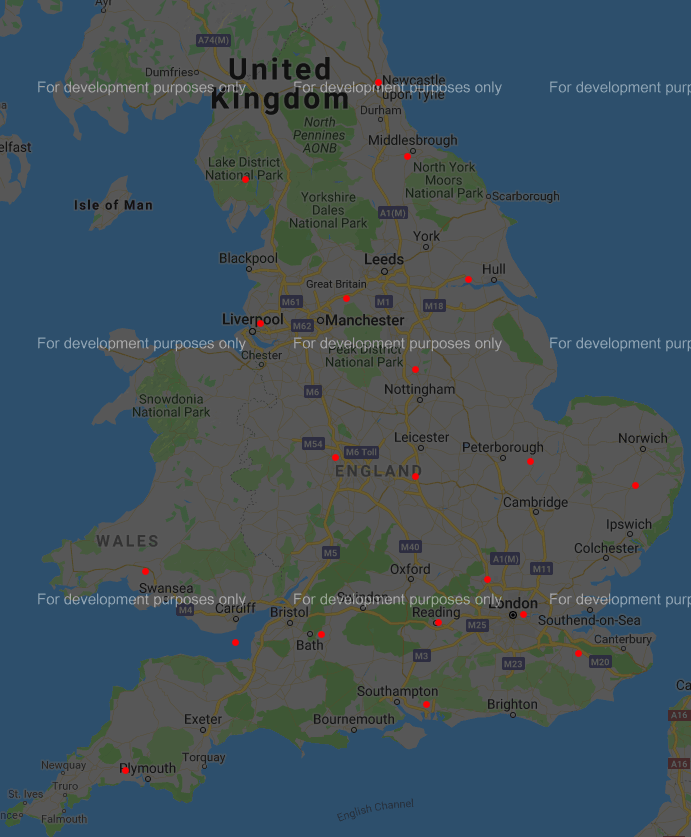

In [99]:
from IPython.display import Image
Image("map.png")

<p><b>Checking for correlations between prices paid and distance from London in Year 2010: </b></p>

In [433]:
df_for_analysis = df_ppd.filter('year == 2010').\
join(df_postcode,'postcode').select(['distance_to_london_km','price'])

rddForAnalysis = df_for_analysis.rdd.map(lambda (sV,sT):Vectors.dense([sV,sT]))
corr_matrix = Statistics.corr(rddForAnalysis)
corr_matrix

array([[ 1.       , -0.2748655],
       [-0.2748655,  1.       ]])

So that a correlation between prices paid and distance from London in Year 2010 was not found.

In [2]:
# HTML for visualization 
from IPython.core.display import HTML
HTML("""
<style> 
h1,h2,p,table,h4{font-family: Helmet, Freesans, Helvetica, Arial, sans-serif;}
h2{padding:0}
p,h4{ font-size: 18px;}
tr{font-size: 16px;}

</style>
""")